In [1]:
# Inference and Reasoning with Bayesian Networks

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Assignment 2 (due: Monday, 16 May, 23:59)

Name: Suraj Narayanan Sasikumar

Student ID: 5881495

## Instructions

|             |Notes|
|:------------|:--|
|Maximum marks| 20|
|Weight|20% of final grade|
|Format| Complete this ipython notebook. Do not forget to fill in your name and student ID above|
|Submission mode| Use [wattle](https://wattle.anu.edu.au/)|
|Formulas| All formulas which you derive need to be explained unless you use very common mathematical facts. Picture yourself as explaining your arguments to somebody who is just learning about your assignment. With other words, do not assume that the person marking your assignment knows all the background and therefore you can just write down the formulas without any explanation. It is your task to convince the reader that you know what you are doing when you derive an argument. Typeset all formulas in $\LaTeX$.|
| Code quality | Python code should be well structured, use meaningful identifiers for variables and subroutines, and provide sufficient comments. Please refer to the examples given in the tutorials. |
| Code efficiency | An efficient implementation of an algorithm uses fast subroutines provided by the language or additional libraries. For the purpose of implementing Machine Learning algorithms in this course, that means using the appropriate data structures provided by Python and in numpy/scipy (e.g. Linear Algebra and random generators). |
| Late penalty | For every day (starts at midnight) after the deadline of an assignment, the mark will be reduced by 5%. No assignments shall be accepted if it is later than 10 days. | 
| Coorperation | All assignments must be done individually. Cheating and plagiarism will be dealt with in accordance with University procedures (please see the ANU policies on [Academic Honesty and Plagiarism](http://academichonesty.anu.edu.au)). Hence, for example, code for programming assignments must not be developed in groups, nor should code be shared. You are encouraged to broadly discuss ideas, approaches and techniques with a few other students, but not at a level of detail where specific solutions or implementation issues are described by anyone. If you choose to consult with other students, you will include the names of your discussion partners for each solution. If you have any questions on this, please ask the lecturer before you act. |

This assignment has two parts. In the first part, you reason using basic rules of probability to estimate the probability and likelihood of different events (maximum 7 marks). In the second part, you implement two different approaches to perform inference on a given Bayesian Network (maximum 13 marks). All formulas and calculations which are not part of Python code should be written using $\LaTeX$.

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$

Setting up the environment

In [2]:
import matplotlib.pyplot as plt
import itertools
import scipy.stats as sp
from copy import deepcopy
from itertools import repeat
import numpy as np
import pandas as pd
import time
import sys

%install_ext https://sml.forge.nicta.com.au/isml16/tutorial/tikzmagic.py

Installed tikzmagic.py. To use it, type:
  %load_ext tikzmagic


/usr/local/lib/python3.4/dist-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


In [3]:
%load_ext tikzmagic
%matplotlib inline

## Part 1: Reasoning and Sampling with Graphical Models

### Problem setting

We are interested to predict the outcome of the election in an imaginary country, called Under Some Assumptions (USA). There are four candidates for whom the citizens can **Vote** for: Bernie, Donald, Hillary, and Ted. The citizens live in four **Region**s: north, south, east and west. We have general demographic information about the people, namely: **Gender** (male, female) and **Hand**edness (right, left). Based on surveys done by an external company, we believe that the **Region** and **Gender** affects whether the people use their **Jacket**s full time, part time or never. Surprisingly, the company told us that the **Age** of their shoes (new, worn, old) depends on how often they wear their **Jacket**s. Furthermore, the **Gender** and their preferred **Hand** affects the **Colour** of their hat (white, black). Finally, surveys say that the citizens will **Vote** based on their **Region**, **Age** of their shoes and **Colour** of their hats.

###  (1 mark) Draw the graphical model

Based on this information, write the directed graphical model using tikz. Note that tikz code has to be in its own code cell.


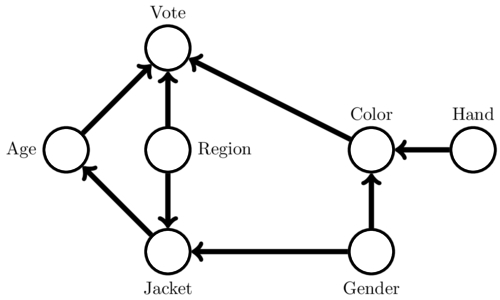

In [4]:
%%tikz --scale 2 --size 500,300 -f jpg
\tikzstyle{vertex}=[circle, draw=black, fill=white, line width=0.5mm, minimum size=25pt, inner sep=0pt]
\tikzstyle{edge} = [draw, line width=1mm, ->]

\node[vertex,label=left:{Age}] (a) at (0,0) {};
\node[vertex,label=above:{Vote}] (v) at (1,1) {};
\node[vertex,label=above:{Color}] (c) at (3,0) {};
\node[vertex,label=right:{Region}] (r) at (1,0) {};
\node[vertex,label=below:{Jacket}] (j) at (1,-1) {};
\node[vertex,label=below:{Gender}] (g) at (3,-1) {};
\node[vertex,label=above:{Hand}] (h) at (4,0) {};

\foreach \source/ \dest in {a/v, r/v, c/v, r/j, j/a, g/j, g/c, h/c}
        \path[edge] (\source) -- (\dest);

### Conditional probability tables

After paying the survey firm some more money, they provided the following conditional probability tables.

|$p(R)$ | R=n | R=s | R=e | R=w |
|:-----:|:--:|:--:|:--:|:--:|
|marginal| 0.2 | 0.1 | 0.5 | 0.2 |

|$p(G)$ | G=m | G=f |
|:-----:|:--:|:--:|
|marginal| 0.3 | 0.7 |

|$p(H)$ | H=r | H=l |
|:-----:|:--:|:--:|
|marginal| 0.9 | 0.1 |

| $p(J|R,G)$ | R=n,G=m | R=n,G=f | R=s,G=m | R=s,G=f | R=e,G=m | R=e,G=f | R=w,G=m | R=w,G=f |
|:-----:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**J**=full $\quad$  |0.9 |0.8 |0.1 | 0.3 |0.4 |0.01| 0.02 | 0.2  |
|**J**=part $\quad$  |0.08|0.17|0.03| 0.35|0.05|0.01| 0.2  | 0.08 |
|**J**=never $\quad$ |0.02|0.03|0.87| 0.35|0.55|0.98| 0.78 | 0.72 |

| $p(A|J)$ | J=full | J=part | J=never |
|:-----:|:--:|:--:|:--:|
|**A**=new  |0.01|0.96|0.3|
|**A**=worn |0.98|0.03|0.5|
|**A**=old  |0.01|0.01|0.2|

| $p(C|G,H)$ | G=m,H=r | G=m,H=l | G=f,H=r | G=f,H=l |
|:-----:|:--:|:--:|:--:|:--:|
|**C**=black $\quad$ |0.9 |0.83 |0.17 | 0.3 |
|**C**=white $\quad$ |0.1 |0.17|0.83 | 0.7 |

The final conditional probability table is given by the matrix below. The order of the rows are alphabetical, and the order of the columns are also given below.

*Hint: The given column name format may not be the best way to code it.*

In [5]:
column_names = ['north,new,black', 'north,new,white', 'north,worn,black', 'north,worn,white', 
                'north,old,black', 'north,old,white', 'south,new,black', 'south,new,white', 
                'south,worn,black', 'south,worn,white', 'south,old,black', 'south,old,white', 
                'east,new,black', 'east,new,white', 'east,worn,black', 'east,worn,white', 
                'east,old,black', 'east,old,white', 'west,new,black', 'west,new,white', 
                'west,worn,black', 'west,worn,white', 'west,old,black', 'west,old,white']

VcRAC_vals = np.array([
        [0.1,0.1,0.4,0.02,0.2,0.1,0.1,0.04,0.2,0.1,0.1 ,0.1,0.4 ,0.1 ,0.1,0.1 ,0.1,0.04,0.3,0.2,0.1,0.3,0.34,0.35],
        [0.3,0.4,0.2,0.5 ,0.1,0.2,0.1,0.5 ,0.1,0.2,0.5 ,0.3,0.2 ,0.42,0.2,0.67,0.4,0.4 ,0.1,0.1,0.5,0.1,0.1 ,0.1],
        [0.5,0.4,0.3,0.3 ,0.5,0.6,0.6,0.3 ,0.5,0.4,0.36,0.3,0.28,0.3 ,0.4,0.1 ,0.4,0.16,0.4,0.2,0.3,0.3,0.4 ,0.5],
        [0.1,0.1,0.1,0.18,0.2,0.1,0.2,0.16,0.2,0.3,0.04,0.3,0.12,0.18,0.3,0.13,0.1,0.4 ,0.2,0.5,0.1,0.3,0.16,0.05]
    ])


### (1 mark) Encode the 7 distributions

Encode the 7 conditional probability tables in python using ```pandas.Series``` and ```pandas.DataFrame```.

Estimate the joint distribution of **Jacket**, **Region** and **Gender**. What is the the probability of full time **Jacket** usage among women in the west?

In [6]:
def __getDFrame(col_names, index_list, col_values):
    """
        Encode Data as Pandas DataFrame with MultiIndex Support
    """
    df = pd.DataFrame(col_values,
         index=pd.MultiIndex.from_tuples(list(zip(*index_list))),
         columns=col_names)
    return df

def __dup_lst_elem(lst, times):
    """ Duplicates each element in the list given number of times"""
    return [x for item in lst for x in repeat(item, times)]

def encodeData():
    """ Encodes all the conditional probability tables as data frames."""
    R_col_names = ['P']
    R_index_list = [['north', 'south', 'east', 'west']]
    R_col_values = [0.2, 0.1, 0.5, 0.2]
    R = __getDFrame(R_col_names, R_index_list, R_col_values)

    G_col_names = ['P']
    G_index_list = [['male', 'female']]
    G_col_values = [0.3, 0.7]
    G = __getDFrame(G_col_names, G_index_list, G_col_values)

    H_col_names = ['P']
    H_index_list = [['right', 'left']]
    H_col_values = [0.9, 0.1]
    H = __getDFrame(H_col_names, H_index_list, H_col_values)

    JcRG_col_names = ['P']
    J_index_list = ['full', 'part', 'never']
    JcRG_index_list = [ __dup_lst_elem(R_index_list[0], 6),
                        __dup_lst_elem(G_index_list[0], 3)*4,
                        J_index_list*24 ]
    JcRG_col_values = [ 0.9, 0.08, 0.02, 0.8, 0.17, 0.03, 0.1, 0.03, 0.87, 0.3,
                        0.35, 0.35, 0.4, 0.05, 0.55, 0.01, 0.01, 0.98, 0.02,
                        0.2, 0.78, 0.2, 0.08, 0.72 ]
    JcRG = __getDFrame(JcRG_col_names, JcRG_index_list, JcRG_col_values)


    AcJ_col_names = ['P']
    A_index_list = ['new', 'worn', 'old']
    AcJ_index_list = [ __dup_lst_elem(J_index_list, 3),
                       A_index_list*9 ]
    AcJ_col_values = [ 0.01, 0.98, 0.01, 0.96, 0.03, 0.01, 0.3, 0.5, 0.2 ]
    AcJ = __getDFrame(AcJ_col_names, AcJ_index_list, AcJ_col_values)


    CcGH_col_names = ['P']
    C_index_list = ['black', 'white']
    CcGH_index_list = [ __dup_lst_elem(G_index_list[0], 4),
                        __dup_lst_elem(H_index_list[0], 2)*2,
                        C_index_list*8 ]
    CcGH_col_values = [ 0.9, 0.1, 0.83, 0.17, 0.17, 0.83, 0.3, 0.7 ]
    CcGH = __getDFrame(CcGH_col_names, CcGH_index_list, CcGH_col_values)

    VcRAC_col_names = ['P']
    V_index_list = ['Bernie', 'Donald', 'Hillary', 'Ted']
    VcRAC_index_list = [ __dup_lst_elem(R_index_list[0], 24),
                        __dup_lst_elem(A_index_list, 8)*4,
                        __dup_lst_elem(C_index_list, 4)*12,
                        V_index_list*96 ]
    VcRAC_col_values = np.array([
            [0.1,0.1,0.4,0.02,0.2,0.1,0.1,0.04,0.2,0.1,0.1 ,0.1,0.4 ,0.1 ,0.1,0.1 ,0.1,0.04,0.3,0.2,0.1,0.3,0.34,0.35],
            [0.3,0.4,0.2,0.5 ,0.1,0.2,0.1,0.5 ,0.1,0.2,0.5 ,0.3,0.2 ,0.42,0.2,0.67,0.4,0.4 ,0.1,0.1,0.5,0.1,0.1 ,0.1],
            [0.5,0.4,0.3,0.3 ,0.5,0.6,0.6,0.3 ,0.5,0.4,0.36,0.3,0.28,0.3 ,0.4,0.1 ,0.4,0.16,0.4,0.2,0.3,0.3,0.4 ,0.5],
            [0.1,0.1,0.1,0.18,0.2,0.1,0.2,0.16,0.2,0.3,0.04,0.3,0.12,0.18,0.3,0.13,0.1,0.4 ,0.2,0.5,0.1,0.3,0.16,0.05]
        ]).flatten('F')
    VcRAC = __getDFrame(VcRAC_col_names, VcRAC_index_list, VcRAC_col_values)
    
    JcRG.sort_index(inplace=True)
    AcJ.sort_index(inplace=True)
    CcGH.sort_index(inplace=True)
    VcRAC.sort_index(inplace=True)

    return (R, G, H, JcRG, AcJ, CcGH, VcRAC)

#Global Namespace START
R, G, H, JcRG, AcJ, CcGH, VcRAC = encodeData()
V_index_list = ['Bernie', 'Donald', 'Hillary', 'Ted']
J_index_list = ['full', 'part', 'never']
G_index_list = ['male', 'female']
R_index_list = ['north', 'south', 'east', 'west']
H_index_list = ['right', 'left']
C_index_list = ['black', 'white']
A_index_list = ['new', 'worn', 'old']
BN = {
    'R':None,
    'G':None,
    'H':None,
    'J':['R', 'G'],
    'A':['J'],
    'C':['G', 'H'],
    'V':['R','A','C']
}
#Global Namespace ENDS

def get_JRG():
    """ Estimate the joint distribution of Jacket, Region and Gender. 
        Prints the probability of full time Jacket usage among women in the west
    """
    #Since Given Nothing R and G and independent P(R,G) = P(R) * P(G)
    P_RG_col_names = ['P']
    P_RG_index_list = [ __dup_lst_elem(R_index_list, 2),
                        G_index_list*4]
    P_RG_col_values = [R['P'][(x[0])]*G['P'][(x[1])] for x in list(zip(*P_RG_index_list))]
    P_RG = __getDFrame(P_RG_col_names, P_RG_index_list, P_RG_col_values)

    #P_JRG = JcRG * P_RG
    P_JRG_col_names = ['P']
    P_JRG_index_list = [ __dup_lst_elem(J_index_list, 8), 
                         __dup_lst_elem(R_index_list, 2)*3,
                         list(G.index)*12]
    P_JRG_col_values = [JcRG['P'][(x[1],x[2],x[0])]*P_RG['P'][(x[1],x[2])] for x in list(zip(*P_JRG_index_list))]
    P_JRG = __getDFrame(P_JRG_col_names, P_JRG_index_list, P_JRG_col_values)

    p_ft_J_w_f = P_JRG['P'][('full','west', 'female')]
    print("\nProbability of full time Jacket usage among women in the west:", p_ft_J_w_f)
    print("Joint Probability Distribution of Jacket, Region, and Gender:")
    P_JRG.index.names=["Jacket","Region","Gender"]
    return P_JRG

get_JRG()


Probability of full time Jacket usage among women in the west: 0.028
Joint Probability Distribution of Jacket, Region, and Gender:


P
Jacket Region Gender        
full   north  male    0.0540
              female  0.1120
       south  male    0.0030
              female  0.0210
       east   male    0.0600
              female  0.0035
       west   male    0.0012
              female  0.0280
part   north  male    0.0048
              female  0.0238
       south  male    0.0009
              female  0.0245
       east   male    0.0075
              female  0.0035
       west   male    0.0120
              female  0.0112
never  north  male    0.0012
              female  0.0042
       south  male    0.0261
              female  0.0245
       east   male    0.0825
              female  0.3430
       west   male    0.0468
              female  0.1008

### (3 marks) Naive sampling approach

Implement the following sampling scheme:
1. Order the nodes in the following fashion, R, G, H, J, A, C, V. Work through each node in order.
2. For the first node R, draw a sample from p(R).
3. For each subsequent node, draw a sample from the conditional distribution $p(X \,|\, parents(X))$ where $parents(X)$ are the parents of the variable $X$ in the graphical model.

Your code should be modular, with appropriate use of (well documented) functions.

In [7]:
def get_sample():
    """ Naive Sampler thats samples from the Graphical Model by using the following node visiting order
        'R', 'G', 'H', 'J', 'A', 'C', 'V'
    """
    sample = {}
    for name, df in zip(['R', 'G', 'H', 'J', 'A', 'C', 'V'],[R, G, H, JcRG, AcJ, CcGH, VcRAC]):
        if BN[name]:
            sampled_values = []
            for pa in BN[name]:
                sampled_values.append(sample[pa])
            df_slice = df['P'][tuple(sampled_values)]
            df_idx = list(df_slice.index)
            sample[name] = np.random.choice(df_idx, p=df_slice)
        else:
            sample[name] = np.random.choice(df.index, p=df['P'])
    return sample

print("\nA single sample:", get_sample())


A single sample: {'V': 'Bernie', 'R': 'west', 'G': 'female', 'H': 'right', 'C': 'white', 'A': 'worn', 'J': 'full'}


The sampler provides a sample from the joint distribution of all random variables. Why was the order in point 1. chosen? Are there other possible orders which achieve the same sampler? If yes, specify another one.

### Solution

The order was chosen so that the random variables appearing later in the order does not have any children in the graphical model. The reasoning behind this is that samples must be drawn from dependent random variables first before the random variables that are conditioned on them can be samples. This ordering ensures that at each step all of the parent values would have been instantiated.

Yes, there are other possible orders as un-conditioned random variables can be samples in any order, and conditioned random variables can be evaluated given the set of random variables it is conditioned on is already samples from.
Examples:
$$
    H \rightarrow R \rightarrow G \rightarrow J \rightarrow A \rightarrow C \rightarrow V \\
    R \rightarrow G \rightarrow H \rightarrow C \rightarrow J \rightarrow A \rightarrow V
$$

Write a small test case to check that your sampler is doing the right thing by using it to verify the sum rule and product rule of probability. You can do so by drawing many samples from both sides of each rule, and show that the proportion of each state is as expected.

In [8]:
def draw_n_samples(n):
    """ Draws n samples from the Distribution of the graphical model."""
    return [get_sample() for _ in range(n)]

print("Drawing 10,000 samples...")
sys.stdout.flush()
start = time.clock()
poll_samples = pd.DataFrame(draw_n_samples(1 * 10**4))
stop  = time.clock() - start
print ('Sampling rate: ', len(poll_samples)/stop, "samples/sec")

Drawing 10,000 samples...
Sampling rate:  439.97780927921116 samples/sec


#### Sum Rule and Product Rule

$$
\begin{align}
P(G) &= \sum_{H} P(G,H) \tag{Sum Rule}\\
P(G,H) &= P(G|H)P(H) \tag{Product Rule}
\end{align}
$$

In [9]:
def __G_H_Joint(poll_samples):
    """ Return the joint distribution of G and H"""
    total_sample_cnt = len(poll_samples)
    P_G_H = [len(poll_samples[(poll_samples['G']=='male')   & (poll_samples['H']=='right')].index)/total_sample_cnt, 
             len(poll_samples[(poll_samples['G']=='female') & (poll_samples['H']=='right')].index)/total_sample_cnt,
             len(poll_samples[(poll_samples['G']=='male')   & (poll_samples['H']=='left')].index)/total_sample_cnt,
             len(poll_samples[(poll_samples['G']=='female') & (poll_samples['H']=='left')].index)/total_sample_cnt ]
    return P_G_H

def sum_rule_LHS(poll_samples):
    """ Evaluates the left hand side of the sum rule specified in the previous cell."""
    total_sample_cnt = len(poll_samples)
    P_G = [len(poll_samples[poll_samples['G']=='male'].index)/total_sample_cnt, 
           len(poll_samples[poll_samples['G']=='female'].index)/total_sample_cnt]
    return P_G

def sum_rule_RHS(poll_samples):
    """ Evaluates the right hand side of the sum rule specified in the previous cell."""
    total_sample_cnt = len(poll_samples)    
    P_G_H = __G_H_Joint(poll_samples)
    SUM_H__P_G_H = [P_G_H[0] + P_G_H[2], P_G_H[1] + P_G_H[3]]
    return SUM_H__P_G_H

def prod_rule_LHS(poll_samples):
    """ Evaluates the left hand side of the product rule specified in the previous cell."""
    return __G_H_Joint(poll_samples)

def prod_rule_RHS(poll_samples):
    """ Evaluates the right hand side of the product rule specified in the previous cell."""
    total_sample_cnt = len(poll_samples)
    H_r_sample = poll_samples[poll_samples['H']=='right']
    H_l_sample = poll_samples[poll_samples['H']=='left']

    P_H = [len(H_r_sample.index)/total_sample_cnt, 
           len(H_l_sample.index)/total_sample_cnt]

    P_GcH = [(len(H_r_sample[H_r_sample['G']=='male'].index)/len(H_r_sample)),
             (len(H_r_sample[H_r_sample['G']=='female'].index)/len(H_r_sample)),
             (len(H_l_sample[H_l_sample['G']=='male'].index)/len(H_l_sample)),
             (len(H_l_sample[H_l_sample['G']=='female'].index)/len(H_l_sample))]
    
    P_G_H = [P_GcH[0]*P_H[0], P_GcH[1]*P_H[0], P_GcH[2]*P_H[1], P_GcH[3]*P_H[1]]
    return P_G_H

def print_sum_product_test_results():
    """ Prints the results of the two test case for sum and product rule"""
    
    print("Drawing two independent pool of 10,000 samples to validate LHS and RHS...")
    LHS_Samples = pd.DataFrame(draw_n_samples(10**4))
    RHS_Samples = pd.DataFrame(draw_n_samples(10**4))

    print("\nSum Rule")
    print("LHS P(G)[male, female]:", sum_rule_LHS(LHS_Samples))
    print("RHS SUM_H(P(G,H))     :", sum_rule_RHS(RHS_Samples))

    print("\nProduct Rule")
    print("LHS P(G,H)[(m,r), (f,r), (m,l), (f,l)]:", prod_rule_LHS(LHS_Samples))
    print("RHS P(G|H)P(H)                        :", prod_rule_RHS(RHS_Samples))
    
print_sum_product_test_results()

Drawing two independent pool of 10,000 samples to validate LHS and RHS...

Sum Rule
LHS P(G)[male, female]: [0.3039, 0.6961]
RHS SUM_H(P(G,H))     : [0.29879999999999995, 0.7012]

Product Rule
LHS P(G,H)[(m,r), (f,r), (m,l), (f,l)]: [0.2736, 0.6261, 0.0303, 0.07]
RHS P(G|H)P(H)                        : [0.26940000000000003, 0.6329, 0.0294, 0.0683]


### (2 marks) Estimating conditional probabilities

Use your sampler above to estimate:
1. the marginal probability of $p(V)$,
2. the probability of women that vote for Hillary, $p(V=Hillary \,|\, G=female)$.

Show a plot that describes the number of samples that are needed to estimate $p(V)$ accurately.



Marginal Probability P(V)[Bernie, Donald, Hilary, Ted]: [0.1569, 0.338, 0.3001, 0.205]

Probability of women voters for Hilary: p(V=Hillary|G=female): 0.27334391687112136

Achieved accuracy of 99.9% consistently after 225 number of samples. The number of samples was estimated when the probability variation among sample sizes stabilized in a tolerance range of 1e-03 for 200 incremental sample size.


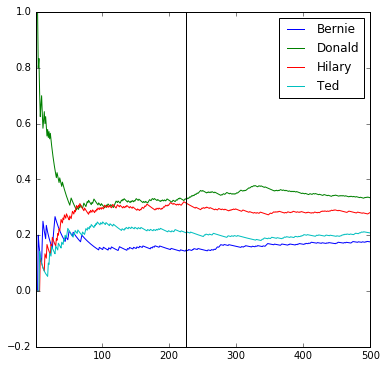

In [10]:
def P_V(poll_samples):
    """ Evaluates the marginal distribution of Votes"""
    total_sample_cnt = len(poll_samples)
    P_V = [len(poll_samples[(poll_samples['V']=='Bernie')].index)/total_sample_cnt, 
             len(poll_samples[(poll_samples['V']=='Donald')].index)/total_sample_cnt,
             len(poll_samples[(poll_samples['V']=='Hillary')].index)/total_sample_cnt,
             len(poll_samples[(poll_samples['V']=='Ted')].index)/total_sample_cnt ]
    return P_V

def P_VcG_for_value(poll_samples, candidate, gender):
    """ Evaluates the conditional distribution of Votes given Gender for a particular instantiation"""
    total_sample_cnt = len(poll_samples)
    G_given_sample = poll_samples[poll_samples['G']==gender]  
    P_VcG_value = (len(G_given_sample[G_given_sample['V']==candidate].index)/len(G_given_sample))
    return P_VcG_value

def get_sample_stream(poll_samples, sub_sample_size, cons = 50, acc=1e-03):
    """ Function to estimate the size of the samples after which we can accurately predict the probabilities.
        Used variance of past probabilities among increasing sample sizes to ensure stabilization.
    """
    sample_stream = []
    accuracy_sample_size = 0
    found = False
    for i in range(1,sub_sample_size):
        sample_stream.append(P_V(poll_samples[:i]))
        if i>cons and not found:
            steam_diff = np.var(sample_stream[-cons:], axis=0)
            if all(np.isclose([0,0,0,0], steam_diff, atol=acc)):
                accuracy_sample_size = i
                found = True
    return (sample_stream, accuracy_sample_size)

def plot_sample_stabilization(sample_size,y, accuracy_sample_size):
    """ Plots the graph of Marginal probabilities of V for which the given maps """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    p = ax.plot(range(1,sample_size), y)
    ax.axvline(accuracy_sample_size, color='k')
    ax.legend(p, ('Bernie', 'Donald', 'Hilary', 'Ted'), loc='upper right')
    ax.set_ylim([-0.2,1])
    ax.set_xlim([1,sample_size])

#Make Under Some Assumptions Great Again!
print("\n\nMarginal Probability P(V)[Bernie, Donald, Hilary, Ted]:", P_V(poll_samples))
print("\nProbability of women voters for Hilary: p(V=Hillary|G=female):", 
      P_VcG_for_value(poll_samples, 'Hillary', 'female'))
    
sub_sample_size = 500
sample_stream, accuracy_sample_size = get_sample_stream(poll_samples, sub_sample_size, 200, 1e-03)
print("\nAchieved accuracy of 99.9% consistently after", accuracy_sample_size, "number of samples.",
       "The number of samples was estimated when the probability variation among sample sizes stabilized in a",
       "tolerance range of 1e-03 for 200 incremental sample size.")
plot_sample_stabilization(sub_sample_size, sample_stream, accuracy_sample_size)

### (3 marks) Direct estimation of conditional probabilities

Write down the expression of the joint probability $p(R,G,H,J,A,C,V)$ in terms of the conditional probabilities in the graphical model.

Use the sum rule and product rule of probability to derive:
* $p(V = Donald \;\,|\, G = male)$
* $p(G = male \,|\, V = Donald)$
* the marginal probability of **Vote**s.

### Solution

> Expression of the joint probability from Graphical Model

$$
\begin{align}
P(R,G,H,J,A,C,V) &= P(R)\,P(G)\,P(H)\,P(J\,|\,R,G)\,P(A\,|\,J)\,P(C\,|\,G,H)\,P(V\,|\,R,A,C)  \tag{1}\\
\end{align}
$$

<br>
>Equation for $P(V=Donald\,|\,G=male)$

$$
\begin{align}
P(V\,|\,G) &= \frac{P(V,G)}{P(G)} \tag{Product Rule}\\
P(V,G) &= \sum_{R,H,J,A,C}P(R,G,H,J,A,C,V) \tag{Sum Rule}\\
P(V\,|\,G) &= \frac{\sum_{R,H,J,A,C}P(R,G,H,J,A,C,V)}{P(G)} \tag{Using Sum & Product Rule}\\
P(V\,|\,G) &= \frac{\sum_{R,H,J,A,C} P(R)\,P(G)\,P(H)\,P(J\,|\,R,G)\,P(A\,|\,J)\,P(C\,|\,G,H)\,P(V\,|\,R,A,C)}{P(G)} \tag{Using 1}\\
P(V\,|\,G) &= \frac{P(G)\sum_{R,H,J,A,C} P(R)\,P(H)\,P(J\,|\,R,G)\,P(A\,|\,J)\,P(C\,|\,G,H)\,P(V\,|\,R,A,C)}{P(G)} \\
P(V\,|\,G) &= \sum_{R,H,J,A,C} P(R)\,P(H)\,P(J\,|\,R,G)\,P(A\,|\,J)\,P(C\,|\,G,H)\,P(V\,|\,R,A,C) \\
\end{align}
$$

> Instantiating V=Donald given G=male

$\Rightarrow P(V=Donald\,|\,G=male) = \sum_{R,H,J,A,C} P(R)\,P(H)\,P(J\,|\,R,G=male)\,P(A\,|\,J)\,P(C\,|\,G=male,H)\,P(V=Donald\,|\,R,A,C)$

<br>
>Equation for $P(G=male\,|\,V=Donald)$

$$
\begin{align}
P(G\,|\,V) &= \frac{P(V,G)}{P(V)} \tag{Product Rule}\\
P(G,V) &= \sum_{R,H,J,A,C}P(R,G,H,J,A,C,V) \tag{Sum Rule}\\
P(G\,|\,V) &= \frac{\sum_{R,H,J,A,C}P(R,G,H,J,A,C,V)}{P(V)} \tag{Using Sum & Product Rule}\\
P(G\,|\,V) &= \frac{\sum_{R,H,J,A,C} P(R)\,P(G)\,P(H)\,P(J\,|\,R,G)\,P(A\,|\,J)\,P(C\,|\,G,H)\,P(V\,|\,R,A,C)}{P(V)} \tag{Using 1}\\
P(G\,|\,V) &= \frac{P(G)\sum_{R,H,J,A,C} P(R)\,P(H)\,P(J\,|\,R,G)\,P(A\,|\,J)\,P(C\,|\,G,H)\,P(V\,|\,R,A,C)}{P(V)} \\
P(G\,|\,V) &= \frac{P(G)}{P(V)}\sum_{R,H,J,A,C} P(R)\,P(H)\,P(J\,|\,R,G)\,P(A\,|\,J)\,P(C\,|\,G,H)\,P(V\,|\,R,A,C) \\
P(G\,|\,V) &= \frac{P(G)}{P(V)} P(V\,|\,G)
\end{align}
$$

> Instantiating G=male given V=Donald

$$\Rightarrow P(G=male\,|\,V=Donald) = \frac{P(G=male)}{P(V=Donald)} P(V=Donald\,|\,G=male)$$

<br>
>Equation for $P(V)$

$$
\begin{align}
P(V) &= \sum_{R,G,H,J,A,C}P(R,G,H,J,A,C,V) \tag{Sum Rule}\\
P(V) &= \sum_{R,G,H,J,A,C} P(R)\,P(G)\,P(H)\,P(J\,|\,R,G)\,P(A\,|\,J)\,P(C\,|\,G,H)\,P(V\,|\,R,A,C)
\end{align}
$$

Using the encoding of the conditional probability tables in ```pandas.Series``` and ```pandas.DataFrame```, and your expressions above, calculate the desired conditional probability tables. Your code should be modular, with appropriate use of (well documented) functions.

In [11]:
def directE_P_VcG(v_given, g_given):
    """ Evaluates the direct probability of Votes given Gender for a particular instantiation.
    """
    P_VcG = 0
    for r in R_index_list:
        m2 = R['P'][(r)]
        for h in H_index_list:
            m1 = H['P'][(h)]
            for c in C_index_list:
                c3 = CcGH['P'][g_given, h, c]
                for a in A_index_list:
                    c4 = VcRAC.loc[r, a, c, v_given]
                    for j in J_index_list:
                        c1 = JcRG.loc[r, g_given, j]
                        c2 = AcJ['P'][(j, a)]
                        P_VcG += m1*m2*c1*c2*c3*c4
    return P_VcG

def directE_P_V():
    """ Evaluates the Marginal Probability of Votes.
    """
    P_V = {}
    for v in V_index_list:
        P_V_instance = 0
        for r in R_index_list:
            m1 = R['P'][(r)]
            for g in G_index_list:
                m2 = G['P'][(g)]
                for h in H_index_list:
                    m3 = H['P'][(h)]
                    for c in C_index_list:
                        c3 = CcGH['P'][g, h, c]
                        for a in A_index_list:
                            c4 = VcRAC.loc[r, a, c, v]
                            for j in J_index_list:
                                c1 = JcRG.loc[r, g, j]
                                c2 = AcJ['P'][(j, a)]                                
                                P_V_instance += m1*m2*m3*c1*c2*c3*c4
        P_V[v] = float(P_V_instance)
    return P_V

def directE_P_GcV(g_given, v_given, P_V=None):
    """ Evaluate Conditional Probability of Gender given Votes for a particular instantiation.
        We use Bayes rule to evaluate this, if marginal is pre-computed, it is re-used.
    """
    if P_V:
        return (G['P'][(g_given)]/P_V[v_given])*directE_P_VcG(v_given, g_given)
    return (G['P'][(g_given)]/directE_P_V()[v_given])*directE_P_VcG(v_given, g_given)
    
def print_direct_estimation_results():
    """ Prints the results for the Direct Estimation section."""
    P_V = directE_P_V()

    VcG_col_names = ['P']
    VcG_index_list = [ __dup_lst_elem(G_index_list, 4),
                       V_index_list*2 ]
    VcG_col_values = [ directE_P_VcG(x[1], x[0]) for x in list(zip(*VcG_index_list))]
    VcG = __getDFrame(VcG_col_names, VcG_index_list, VcG_col_values)
    VcG.index.names=["Gender","Vote"]

    GcV_col_names = ['P']
    GcV_index_list = [ __dup_lst_elem(V_index_list, 2),
                       G_index_list*4 ]
    GcV_col_values = [ directE_P_GcV(x[1], x[0], P_V=P_V) for x in list(zip(*GcV_index_list))]
    GcV = __getDFrame(GcV_col_names, GcV_index_list, GcV_col_values)
    GcV.index.names=["Vote","Gender"]


    v_given = 'Donald'
    g_given = 'male'

    print ("\n\nP(V=" + v_given + " | G=" + g_given + "):", VcG['P'][(g_given,v_given)])
    print ("\nP(G=" + g_given + " | V=" + v_given + "):", GcV['P'][(v_given, g_given)])
    print ("\nP(V):", P_V)
    print("\nP(V|G)\n", VcG)
    print("")
    print("\nP(G|V)\n", GcV)
    
print_direct_estimation_results()



P(V=Donald | G=male): 0.2464847735

P(G=male | V=Donald): 0.214321628636

P(V): {'Ted': 0.2046562491599999, 'Bernie': 0.15481761531999996, 'Hillary': 0.2955052782200001, 'Donald': 0.34502085730000004}

P(V|G)
                        P
Gender Vote             
male   Bernie   0.205460
       Donald   0.246485
       Hillary  0.358109
       Ted      0.189947
female Bernie   0.133114
       Donald   0.387251
       Hillary  0.268675
       Ted      0.210960


P(G|V)
                        P
Vote    Gender          
Bernie  male    0.398133
        female  0.601867
Donald  male    0.214322
        female  0.785678
Hillary male    0.363556
        female  0.636444
Ted     male    0.278438
        female  0.721562


Report the tables above in markdown.

### Solution

| $P(V|G)$ | G=male | G=female|
|:-----:|:--:|:--:|
|**V**=Bernie  |0.205460|0.133114|
|**V**=Donald  |0.246485|0.387251|
|**V**=Hillary |0.358109|0.268675|
|**V**=Ted     |0.189947|0.210960|

| $P(G|V)$ | V=Bernie | V=Donald | V=Hillary | V=Ted|
|:-----:|:--:|:--:|:--:|:--:|
|**G**=male    |0.398133|0.214322|0.363556|0.278438|
|**G**=female  |0.601867|0.785678|0.636444|0.721562|

| $P(V)$ | V=Bernie | V=Donald | V=Hillary | V=Ted|
|:-----:|:--:|:--:|:--:|:--:|
|marginal    |0.15481761531999996|0.34502085730000004|0.2955052782200001|0.2046562491599999|

### (3 marks) Estimating structure

It turns out that the external company that we used to estimate the probabilities above did not do such a good job. There is reason to believe that the given graphical model above is wrong. However, it is believed that the true graphical model has more or less the same number of edges, and is sharing some conditional probability tables. In particular, assume that the conditional probability table for **Voting** conditioned on **Region**, **Age** and **Colour** remains the same. 

An enterprising student from the Amazing Neighbourhood University (ANU) obtained some data by polling. This data is available from [this website](https://sml.forge.nicta.com.au/isml16/assignments/poll-data.csv.gz). Use this data to identify a good graphical model.

Show:
1. The tikz image of the graphical model (this has to be in its own cell)
2. The conditional probability tables as markdown

Argue why the new graphical model that you estimated from the data is a good one.

*A majority of marks are allocated for the method of finding the graphical model.*

In [12]:
def get_full_joint_from_data(given_data_df, values_dict):
    """ Obtain the full joint distribution from the data set
        P(R,G,H,J,A,C,V)
    """
    indices = (
        values_dict['Region'],
        values_dict['Gender'],
        values_dict['Handedness'],
        values_dict['Jacket'],
        values_dict['Age'],
        values_dict['Colour'],
        values_dict['Vote']
    )
    c_names = ['Region', 'Gender', 'Handedness',
               'Jacket', 'Age', 'Colour', 'Vote']
    full_joint_df = pd.DataFrame(
        np.nan, index=pd.MultiIndex.from_product(indices, names=c_names),
        columns=['P'])
    total_sample_cnt = len(given_data_df)
    for comb in list(itertools.product(*indices)):
        p = len(given_data_df[
                (given_data_df['Region'] == comb[0]) &
                (given_data_df['Gender'] == comb[1]) &
                (given_data_df['Handedness'] == comb[2]) &
                (given_data_df['Jacket'] == comb[3]) &
                (given_data_df['Age'] == comb[4]) &
                (given_data_df['Colour'] == comb[5]) &
                (given_data_df['Vote'] == comb[6])
                ].index) / total_sample_cnt
        full_joint_df['P'][comb] = p
    return full_joint_df


def get_model_joint(BN, values_dict, data):
    """ Obtain the Joint distribution of the current model under consideration
        This obtained by multiplying the model parameters.
    """
    inv_BN = {}
    for v in BN:
        for e in BN[v]:
            if e not in inv_BN:
                inv_BN[e] = []
            inv_BN[e].append(v)
    for v in BN:
        if v not in inv_BN:
            inv_BN[v] = []

    model_params = {}
    for key, value in inv_BN.items():
        if value == []:
            model_params[key] = get_marginal_from_data(
                key, values_dict, data)
        else:
            model_params[key] = get_conditional_from_data(
                key, value, values_dict, data)

    indices = (
        values_dict['Region'],
        values_dict['Gender'],
        values_dict['Handedness'],
        values_dict['Jacket'],
        values_dict['Age'],
        values_dict['Colour'],
        values_dict['Vote']
    )
    c_names = ['Region', 'Gender', 'Handedness',
               'Jacket', 'Age', 'Colour', 'Vote']
    full_joint_df = pd.DataFrame(
        np.nan, index=pd.MultiIndex.from_product(indices, names=c_names),
        columns=['P'])
    idx_map = {
        'Region': 0,
        'Gender': 1,
        'Handedness': 2,
        'Jacket': 3,
        'Age': 4,
        'Colour': 5,
        'Vote': 6
    }
    for comb in list(itertools.product(*indices)):
        p = 1
        for key, param in model_params.items():
            idx_param = [key] + inv_BN[key]
            sub_list = []
            for var in idx_param:
                sub_list.append(comb[idx_map[var]])
            p *= param['P'].loc[tuple(sub_list)]
        full_joint_df['P'][comb] = p

    return full_joint_df


def get_marginal_from_data(var, values_dict, data):
    """ Obtain the marginal distribution of a given variable from the data
    """
    indices = [values_dict[var]]
    c_names = [var]

    marg_df = pd.DataFrame(
        np.nan, index=pd.MultiIndex.from_product(indices, names=c_names),
        columns=['P'])

    for comb in list(itertools.product(*indices)):
        p = len(data[(data[var]) == comb[0]].index) / len(data)
        marg_df['P'][comb] = p

    return marg_df


def get_conditional_from_data(var, given, values_dict, data):
    """ Obtain the conditional distribution from the data.
    """
    indices = [values_dict[var]]
    for g in given:
        indices.append(values_dict[g])
    c_names = [var] + given

    cond_df = pd.DataFrame(
        np.nan, index=pd.MultiIndex.from_product(indices, names=c_names),
        columns=['P'])

    # reduce samples
    for comb in list(itertools.product(*indices)):
        given_sample_space = data[:]
        for idx, val in enumerate(comb[1:]):
            given_sample_space = given_sample_space[
                (given_sample_space[given[idx]] == val)]
        if len(given_sample_space) == 0:
            p = 10**-4
        else:
            p = len(given_sample_space[(given_sample_space[var]) == comb[
                    0]].index) / len(given_sample_space)
        cond_df['P'][comb] = p
    return cond_df


def cyclic(g):
    """Return True if the directed graph g has a cycle.
    g must be represented as a dictionary mapping vertices to
    iterables of neighbouring vertices. For example:

    >>> cyclic({1: (2,), 2: (3,), 3: (1,)})
    True
    >>> cyclic({1: (2,), 2: (3,), 3: (4,)})
    False

    Reference: http://codereview.stackexchange.com/a/86067
    """
    path = set()
    visited = set()

    def visit(vertex):
        if vertex in visited:
            return False
        visited.add(vertex)
        path.add(vertex)
        for neighbour in g.get(vertex, ()):
            if neighbour in path or visit(neighbour):
                return True
        path.remove(vertex)
        return False

    return any(visit(v) for v in g)


def main():
    V_index_list = ['Bernie', 'Donald', 'Hillary', 'Ted']
    J_index_list = ['full', 'part', 'never']
    G_index_list = ['male', 'female']
    R_index_list = ['north', 'south', 'east', 'west']
    H_index_list = ['right', 'left']
    C_index_list = ['black', 'white']
    A_index_list = ['new', 'worn', 'old']

    values = {
        'Region': R_index_list,
        'Gender': G_index_list,
        'Handedness': H_index_list,
        'Jacket': J_index_list,
        'Age': A_index_list,
        'Colour': C_index_list,
        'Vote': V_index_list
    }

    # Reading Data
    better_samples = pd.read_csv('poll-data.csv')

    # Taking full joint on data
    print("\nTaking the full joint on data, this might take 20-30 seconds...")
    sys.stdout.flush()
    full_joint_df = list(get_full_joint_from_data(better_samples, values)['P'])

    # Topologically  Ordered Baeysian Net

    BN_root_model = {
        'Region': ['Vote', 'Jacket'],
        'Gender': ['Jacket', 'Colour'],
        'Handedness': ['Colour'],
        'Jacket': ['Age'],
        'Age': ['Vote'],
        'Colour': ['Vote'],
        'Vote': []
    }

    def bn_2_tup(BN):
        """Save model as a hashable object for comparison in search space."""
        tup_list = []
        for k in sorted(list(BN.keys())):
            for v in BN[k]:
                tup_list.append((k, v))
        return tuple(tup_list)

    closed_list = []

    # Use KL Divergence to compare the Joint distribution of the current model
    # with the Joint distribution of the data.
    model_joint = get_model_joint(BN_root_model, values, better_samples)
    score = sp.entropy(full_joint_df, qk=list(model_joint['P']))
    closed_list.append(bn_2_tup(BN_root_model))

    # Run multiple epochs to get a good Model consistently.
    min_score = (BN_root_model, score)
    for i in range(5):
        print("Running epoch:", i)
        sys.stdout.flush()
        BN_new = deepcopy(min_score[0])
        for edge in list(itertools.product(*[list(values.keys()), list(values.keys())])):
            rem_add = np.random.choice([True, False], p=[0.8, 0.2])
            if rem_add:
                if edge[1] in BN_new[edge[0]]:
                    # Fixing VcRAC as per question.
                    if edge[1] == 'Vote' and (edge[0] == 'Region' or edge[0] == 'Age' or edge[0] == 'Colour'):
                        continue
                    BN_new[edge[0]].remove(edge[1])
            else:
                if edge[1] not in BN_new[edge[0]]:
                    BN_new[edge[0]].append(edge[1])
                    if cyclic(BN_new):
                        BN_new[edge[0]].remove(edge[1])
                        continue
            if bn_2_tup(BN_new) in closed_list:
                continue
            model_joint = get_model_joint(BN_new, values, better_samples)
            score = sp.entropy(full_joint_df, qk=list(model_joint['P']))
            closed_list.append(bn_2_tup(BN_new))
            if score < min_score[1]:
                min_score = (BN_new, score)
    print("Optimal Structure:", min_score[0])
    print("KL Divergence score:", min_score[1])
    return min_score[0]

good_beysian_model = main()



Taking the full joint on data, this might take 20-30 seconds...
Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Optimal Structure: {'Age': ['Vote', 'Handedness'], 'Jacket': ['Colour', 'Gender'], 'Region': ['Vote'], 'Colour': ['Vote', 'Age'], 'Vote': ['Handedness'], 'Gender': ['Vote'], 'Handedness': []}
KL Divergence score: 0.0176165677077


Because of the randomization component in the algorithm, in subsequent runs the algorithm returns a better model but not the same model. Hence the following is the report for the displayed Graphical Model:

**Optimal Structure**: ```{'Gender': [], 'Jacket': ['Gender'], 'Vote': [], 'Colour': ['Vote', 'Jacket', 'Region'], 'Age': ['Vote'], 'Region': ['Vote', 'Gender', 'Jacket'], 'Handedness': []}```

**KL Divergence score**: 0.0495563107728

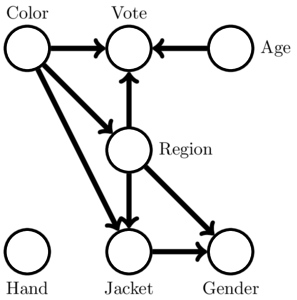

In [13]:
%%tikz --scale 2 --size 500,300 -f jpg
\tikzstyle{vertex}=[circle, draw=black, fill=white, line width=0.5mm, minimum size=25pt, inner sep=0pt]
\tikzstyle{edge} = [draw, line width=1mm, ->]

\node[vertex,label=right:{Age}] (a) at (2,1) {};
\node[vertex,label=above:{Vote}] (v) at (1,1) {};
\node[vertex,label=above:{Color}] (c) at (0,1) {};
\node[vertex,label=right:{Region}] (r) at (1,0) {};
\node[vertex,label=below:{Jacket}] (j) at (1,-1) {};
\node[vertex,label=below:{Gender}] (g) at (2,-1) {};
\node[vertex,label=below:{Hand}] (h) at (0,-1) {};

\foreach \source/ \dest in {j/g, c/v, c/j, c/r, a/v, r/v, r/g, r/j}
        \path[edge] (\source) -- (\dest);

### Solution

The Graphical Model is produced by comparing the model parameters that best fits the given data. Primarily the process is we add and remove edges from an initial known model to maximize a model score. The know model in this case is model with the 8 edges and a factorization term guaranteed $P(V\,|\,RAC)$.

Each model configuration has a valid factorization of its joint distribution, the individual term in the factorization are called model parameters. To calculate the relevance of a graphical model with respect to a given data we multiply out this factorization term and obtain the joint distribution for the graphical model. 

Since we have the complete data we can calculate the full joint distribution of the data. Once we have the two joint distributions, i.e. one from the graphical model and one from the data, we calculate the $\mathcal{KL}$-Divergence for the two distributions inorder to obtain a (dis)similarity score. The similarity we measure is between the model and the data.

Using this similarity score we go through all the possible model configuration that has 7-9 edges and holds the conditional probability $P(V\,|\,RAC)$ to obtain a model that minimizes the score.

Since the $\mathcal{KL}$-Divergence score of the graphical model w.r.t. the data is less than the score of the model that was presented at the start of the assignment, it is clearly a better model.

## Part 2: Analysis of algorithms

### (4 marks) Incremental EM
$\newcommand{\B}[1]{\mathbf{#1}}$
$\newcommand{\Btheta}{\boldsymbol{\mathsf{\theta}}}$
$\newcommand{\Cond}{\,|\,}$

Given are $N$ independent data points $\B{x}_1,\dots,\B{x}_N$ and a Gaussian mixture model with corresponding latent variables $\B{z}_1,\dots,\B{z}_N$. As the joint distribution $p(\B{X}, \B{Z} \Cond \Btheta)$ factorises over the data points, one can develop an incremental form of EM in which only one data point is processed in each E- and M-step if the mixture component is a member of the exponential family. 

Consider a mixture of Gaussians. The update for the effective number of data points $N_k$ after having seen data point $\B{x}_m$ can be derived as
$$
  N_k^\text{new} = N_k^\text{old} + \gamma^\text{new}(z_{mk}) - \gamma^\text{old}(z_{mk})
$$

1. Define $\gamma^\text{new}(z_{mk})$.
- Prove the above given result for the update of $N_k$.
- Develop the update formulas for the other parameters of the Gaussian mixture model: 
  - mixture coefficients $\mathsf{\pi}_k$, 
  - means $\mathsf{\mu}_k$, and 
  - covariances $\mathsf{\Sigma}_k$.
- Define and explain two properties of this incremental EM algorithm which make it preferable method over batch EM.

### Solution

#### Define $\gamma^{new}(z_{mk})$

$\gamma^{new}(z_{mk})$ denotes the *responsibility* each Gaussian in the Mixture takes towards explaining the occurance of the point $\mathbf{x}_m$. It can also be viewed as a predictive distribution answering, give a data point what is the probability that it belongs to a particular cluster. In incremental EM, during the E-step responsibilities are re-evaluated only for one point. Hence during the computation of $\gamma^{new}(z_{mk})$, it depends on the *old* parameters of the gaussian mixture, therefore $\gamma^{new}(z_{mk})$ can be defines as:

$$
\gamma^{new}(z_mk) = \frac{\pi_k^{old}\mathcal{N}(\mathbf{x}_m|\mathbf{\mu}_k^{old},\mathbf{\Sigma}_k^{old})}{\sum_{j=1}^{K}\pi_j^{old}\mathcal{N}(\mathbf{x}_m|\mathbf{\mu}_j^{old},\mathbf{\Sigma}_j^{old})}
$$

#### Proof for $N_k^\text{new} = N_k^\text{old} + \gamma^\text{new}(z_{mk}) - \gamma^\text{old}(z_{mk})$

$N_k$ is the sum of contribution of individual responsibilities all the points have towards one cluster. It is an effective measure of the number of points in a given cluster $k$. It is defined as:

$$
N_k = \sum_{n=1}^{N}\gamma^(z_{nk})
$$

The crucial point about incremental EM algorithm is that the responsibilities of only one data-point is re-evaluated in the E-step, i.e. for a given cluster $k$, for all the $\gamma(z_k)$ of the *old* E-step only $\gamma(\mathbf{z}_{mk})$ gets updated. Subsequently $N_k^{new}$, after re-evaluating $\gamma(z_{mk})$ from $\gamma^{old}(z_{mk})$ to $\gamma^{new}(z_{mk})$ can be written as:

$$
\begin{align}
N_k^{new} &= \sum_{n,n \neq m,n\in N}\gamma^{old}(z_{nk}) + \gamma^{new}(z_{mk}) \tag{1}\\
N_k^{new} &= \sum_{n,n \neq m,n\in N}\gamma^{old}(z_{nk}) + \gamma^{new}(z_{mk}) + \gamma^{old}(z_{mk}) - \gamma^{old}(z_{mk}) \tag{Add & subtract same term} \\
N_k^{new} &= \Big(\sum_{n,n \neq m,n\in N}\gamma^{old}(z_{nk}) + \gamma^{old}(z_{mk}) \Big) + \gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk}) \tag{2}
\end{align}
$$

The sum of all the unchanged responsibilites of the other points not evaluated in this E-step plus the old responsibility of the data point considered in the current step is the same value as the old effective number, $N_k^{old}$, i.e.,

$$
\begin{align}
N_k^{old} &= \sum_{n,n \neq m,n\in N}\gamma^{old}(z_{nk}) + \gamma^{old}(z_{mk}) \tag{3}\\
\Rightarrow N_k^{new} &= N_k^{old} + \gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk}) \tag{Using 2 & 3}
\end{align}
$$
**Q.E.D**

#### Update formula for $\pi_k$

The mixing coefficient can be seen as the fraction of the points that belong to a cluster. It is defined as:
$$
\pi_k = \frac{N_k}{N}
$$
After the M-step, along with the re-evaluated $N_k^{new}$ from the E-Step, $\pi_k^{new}$ can be written as:

$$
\pi_k^{new} = \frac{N_k^{new}}{N}
$$

Using the given update result of $N_k^{new}$, we can re-write $\pi_k$ as:

$$
\begin{align}
\pi_k^{new} &= \frac{N_k^{old} + \gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})}{N}\\
\pi_k^{new} &= \frac{N_k^{old}}{N} + \frac{\gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})}{N} \tag{1}
\end{align}
$$

By definition,
$$
\pi_k^{old} = \frac{N_k^{old}}{N} \tag{2}
$$

Hence the update formula for $\pi_k$ is given by,
$$
\begin{align}
\pi_k^{new} &= \pi_k^{old} + \frac{\gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})}{N} \tag{Using 1 and 2}
\end{align}
$$

#### Update formula for $\mu_k$

The parameter $\mu_k$ is the mean of cluster $k$, for a gaussian mixture, this is the mean of the $k^{th}$ gaussian in the mixture. It is nothing but the weighted responsibility of each point towards the clusters, normalized by the total number of points in the cluster. In the M-step of the EM algorithm we get the value of $\mu_k$ that maximizes the likelihood function to be defined as:

$$
\mathbf{\mu}_k = \frac{\sum_{n=1}^{N}\gamma (z_{nk})\mathbf{x}_n}{N_k}
$$

By definition:

$$
\mathbf{\mu}_k^{new} = \frac{\sum_{n=1}^{N}\gamma^{new} (z_{nk})\mathbf{x}_n}{N_k^{new}}
$$

The crucial point about incremental EM algorithm is that the responsibilities of only one data-point is re-evaluated in the E-step, i.e. for a given cluster $k$, for all the $\gamma(z_k)$ of the *old* E-step, only $\gamma(\mathbf{z}_{mk})$ gets updated. Subsequently \mathbf{\mu}_k^{new}, after re-evaluating $\gamma(z_{mk})$ from $\gamma^{old}(z_{mk})$ to $\gamma^{new}(z_{mk})$ can be written as:

$$
\begin{align}
\Rightarrow \mathbf{\mu}_k^{new} &= \frac{\displaystyle\sum_{n,n \neq m,n\in N}\gamma^{old}(z_{nk})\mathbf{x}_n + \gamma^{new}(z_{mk})\mathbf{x}_n}{N_k^{new}}\\
\mathbf{\mu}_k^{new} &= \frac{\displaystyle\sum_{n,n \neq m,n\in N}\gamma^{old}(z_{nk})\mathbf{x}_n + \gamma^{new}(z_{mk})\mathbf{x}_n + \gamma^{old}(z_{mk})\mathbf{x}_m - \gamma^{old}(z_{mk})\mathbf{x}_m}{N_k^{new}} \tag{Add & Subtract} \\
\mathbf{\mu}_k^{new} &= \frac{\Big(\displaystyle\sum_{n,n \neq m,n\in N}\gamma^{old}(z_{nk})\mathbf{x}_n + \gamma^{old}(z_{mk})\mathbf{x}_m \Big) + \gamma^{new}(z_{mk})\mathbf{x}_n - \gamma^{old}(z_{mk})\mathbf{x}_m}{N_k^{new}} \tag{Collecting terms}\\
\mathbf{\mu}_k^{new} &= \frac{\displaystyle\sum_{n=1}^{N}\gamma^{old}(z_{nk})\mathbf{x}_n + \gamma^{new}(z_{mk})\mathbf{x}_n - \gamma^{old}(z_{mk})\mathbf{x}_m}{N_k^{new}} \tag{1}
\end{align}
$$

By Definition:

$$
\mathbf{\mu}_k^{old} = \frac{\sum_{n=1}^{N}\gamma^{old} (z_{nk})\mathbf{x}_n}{N_k^{old}}
\Rightarrow \sum_{n=1}^{N}\gamma^{old} (z_{nk})\mathbf{x}_n = \mathbf{\mu}_k^{old} N_k^{old} \tag{2}
$$

From $Eq.(1)$ and $Eq.(2)$:

$$
\begin{align}
\mathbf{\mu}_k^{new} &= \frac{ \mathbf{\mu}_k^{old} N_k^{old} + \gamma^{new}(z_{mk})\mathbf{x}_n - \gamma^{old}(z_{mk})\mathbf{x}_m}{N_k^{new}}\\
\mathbf{\mu}_k^{new} &= \frac{ \mathbf{\mu}_k^{old} N_k^{old}}{N_k^{new}} + \frac{\big(\gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})\big)\mathbf{x}_m}{N_k^{new}} \tag{3}
\end{align}
$$

Re-ordering the given update formula for $N_k^{new}$,
$$
  N_k^\text{old} = N_k^\text{new} - \big(\gamma^\text{new}(z_{mk}) - \gamma^\text{old}(z_{mk})\big) \tag{4}
$$

From $Eq.(3)$ and $Eq.(4)$

$$
\begin{align}
\mathbf{\mu}_k^{new} &= \frac{ \mathbf{\mu}_k^{old} N_k^\text{new} - \mathbf{\mu}_k^{old}\big(\gamma^\text{new}(z_{mk}) - \gamma^\text{old}(z_{mk})\big)}{N_k^{new}} + \frac{\big(\gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})\big)\mathbf{x}_m}{N_k^{new}}\\
\mathbf{\mu}_k^{new} &= \mathbf{\mu}_k^{old} + \frac{\big(\gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})\big)\mathbf{x}_m - \big(\gamma^\text{new}(z_{mk}) - \gamma^\text{old}(z_{mk})\big)\mathbf{\mu}_k^{old}}{N_k^{new}}{N_k^{new}} \tag{Re-arranging}\\
\end{align}
$$

Hence the update formula for $\mu_k$ is given by:

$$
\mathbf{\mu}_k^{new} = \mathbf{\mu}_k^{old} + \Bigg(\frac{\big(\gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})\big)}{{N_k^{new}}}\Bigg)(\mathbf{x}_m -\mathbf{\mu}_k^{old}) \tag{Re-arranging}
$$

#### Update formula for $\Sigma_k$

The covariance matrix of the Gaussian representing the $k^{th}$ cluster signifies the variance of all the data points from the mean of the gaussian. In the M-step of the EM algorithm we get the value of $\Sigma_k$ that maximizes the likelihood function to be defined as:

$$
\Sigma_k = \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})(\mathbf{x}_n - \mathbf{\mu}_{k})(\mathbf{x}_n -\mathbf{\mu}_{k})^T
$$

By definition:

$$
\Sigma_k^{new} = \frac{1}{N_k^{new}}\sum_{n=1}^N\gamma^{new}(z_{nk})(\mathbf{x}_n - \mathbf{\mu}_{k}^{new})(\mathbf{x}_n -\mathbf{\mu}_{k}^{new})^T \\
$$

The crucial point about incremental EM algorithm is that the responsibilities of only one data-point is re-evaluated in the E-step, i.e. for a given cluster $k$, for all the $\gamma(z_k)$ of the *old* E-step, only $\gamma(\mathbf{z}_{mk})$ gets updated. Subsequently \mathbf{\Sigma}_k^{new}, after re-evaluating $\gamma(z_{mk})$ from $\gamma^{old}(z_{mk})$ to $\gamma^{new}(z_{mk})$ can be written as:

$$
\Sigma_k^{new} = \frac{1}{N_k^{new}}\Bigg(\displaystyle\sum_{n,n \neq m,n\in N}\gamma^{old}(z_{nk})(\mathbf{x}_n - \mathbf{\mu}_{k}^{old})(\mathbf{x}_n -\mathbf{\mu}_{k}^{old})^T + \gamma^{new}(z_{mk})(\mathbf{x}_m - \mathbf{\mu}_{k}^{new})(\mathbf{x}_m -\mathbf{\mu}_{k}^{new})^T\Bigg)
$$

By definition:

$$
\begin{align}
\Sigma_k^{old} &= \frac{1}{N_k^{old}}\sum_{n=1}^N\gamma^{old}(z_{nk})(\mathbf{x}_n - \mathbf{\mu}_{k}^{old})(\mathbf{x}_n -\mathbf{\mu}_{k}^{old})^T \\
\Rightarrow N_k^{old}\Sigma_k^{old} &= \sum_{n=1}^N\gamma^{old}(z_{nk})(\mathbf{x}_n - \mathbf{\mu}_{k}^{old})(\mathbf{x}_n -\mathbf{\mu}_{k}^{old})^T \tag{1}
\end{align}
$$

After adding and subtracting $\gamma^{old}(z_{mk})(\mathbf{x}_m - \mathbf{\mu}_{k}^{old})(\mathbf{x}_m -\mathbf{\mu}_{k}^{old})^T$ and collapsing $+\gamma^{old}(z_{mk})(\mathbf{x}_m - \mathbf{\mu}_{k}^{old})(\mathbf{x}_m -\mathbf{\mu}_{k}^{old})^T$ into the summation, we get:

$$
\Sigma_k^{new} = \frac{\Bigg(\displaystyle\sum_{n=1}^{N}\gamma^{old}(z_{nk})(\mathbf{x}_n - \mathbf{\mu}_{k}^{old})(\mathbf{x}_n -\mathbf{\mu}_{k}^{old})^T + \gamma^{new}(z_{mk})(\mathbf{x}_m - \mathbf{\mu}_{k}^{new})(\mathbf{x}_m -\mathbf{\mu}_{k}^{new})^T - \gamma^{old}(z_{mk})(\mathbf{x}_m - \mathbf{\mu}_{k}^{old})(\mathbf{x}_m -\mathbf{\mu}_{k}^{old})^T\Bigg)}{N_k^{new}}  \tag{2}\\
$$

From $Eq.(1)$ and $Eq.(2)$:

$$
\Sigma_k^{new} = \frac{1}{N_k^{new}}\Bigg(N_k^{old}\Sigma_k^{old} + \gamma^{new}(z_{mk})(\mathbf{x}_m - \mathbf{\mu}_{k}^{new})(\mathbf{x}_m -\mathbf{\mu}_{k}^{new})^T - \gamma^{old}(z_{nk})(\mathbf{x}_m - \mathbf{\mu}_{k}^{old})(\mathbf{x}_m -\mathbf{\mu}_{k}^{old})^T\Bigg) \tag{3}
$$

Re-ordering the given update formula for $N_k^{new}$,
$$
  N_k^\text{old} = N_k^\text{new} - \big(\gamma^\text{new}(z_{mk}) - \gamma^\text{old}(z_{mk})\big) \tag{4}
$$

From $Eq.(3)$ and $Eq.(4)$
$$
\Sigma_k^{new} = \frac{1}{N_k^{new}}\Bigg(\Sigma_k^{old}\big(N_k^\text{new} - \big(\gamma^\text{new}(z_{mk}) - \gamma^\text{old}(z_{mk})\big)\big) + \gamma^{new}(z_{mk})(\mathbf{x}_m - \mathbf{\mu}_{k}^{new})(\mathbf{x}_m -\mathbf{\mu}_{k}^{new})^T - \gamma^{old}(z_{nk})(\mathbf{x}_m - \mathbf{\mu}_{k}^{old})(\mathbf{x}_m -\mathbf{\mu}_{k}^{old})^T\Bigg)
$$

Rearraging terms, and extracting like terms, we get the update formula for $\Sigma_k$ as follows:

$$
\Sigma_k^{new} = \Sigma_k^{old} + \Bigg(\frac{\gamma^\text{new}(z_{mk})\big((\mathbf{x}_m - \mathbf{\mu}_{k}^{new})(\mathbf{x}_m -\mathbf{\mu}_{k}^{new})^T - \Sigma_k^{old}\big) - \gamma^\text{old}(z_{mk})\big((\mathbf{x}_m - \mathbf{\mu}_{k}^{old})(\mathbf{x}_m -\mathbf{\mu}_{k}^{old})^T - \Sigma_k^{old}\big)}{N_k^{new}}\Bigg)
$$


#### Properties of Incremental EM algorithm

##### 1. Incremental EM algorithm converges faster than Batch EM

Iterating over $N$ data points taken one at a time converges faster than batch EM since during each EM cycle the parameters of the distribution is revised, whearas in batch EM, it is revised only after all the whole data set is processed.

##### 2. Constant Time EM Step

In incremental EM we are looking at only one data point at a time, thus both the E and M step take constant time independent of the total number of data points. Whereas in batch EM, during one EM cycle it iterates through all the data point. This is especially pronounced where the data is huge, like in Big Data applications.

### (3 marks) Sampling from a piecewise exponential distribution

In the lecture we mentioned sampling from the *exponential distribution*
given by
$$
  p(y) = \lambda e^{-\lambda y}.
$$

The *piecewise exponential distribution* is defined as
$$
  p(z) = k_m \lambda_m e^{-\lambda_m (z - z_m)} 
         \qquad \qquad  
         \widehat{z}_{m-1,m} < z \le \widehat{z}_{m,m+1}
$$
where $ \widehat{z}_{m-1, m} $ is the point of intersection of the tangent 
lines at $ z_{m-1} $ and $ z_m $,
$ \lambda_m $ is the slope of the tangent at $ z_m $ and 
$ k_m $ accounts for the corresponding offset.

(a) Using the result for sampling from a single distribution,
devise an algorithm for sampling from the piecewise 
distribution.

(b) Given a desired distribution $ p(z) $, describe precisely how the 
piecewise exponential distribution can be used to sample from this
distribution.

(c) Explain how one can use rejected samples to better 
approximate the desired distribution $ p(z) $.



### Solution

#### Algorithm for sampling from the piecewise exponential distribution

Sampling a distribution $p(y)$ takes the following, algorithmic approach:
* Sample a point $z$ from the uniform distribution $\mathcal{U(0,1)}$ using a random number generator
* Transform the uniformly distributed variable using the inverse Cumulative Distribution Function (CFD), $h^{-1}(z)$
* The variable $y = h^{-1}(z)$ now has the distribution of $p(y)$

The piecewise exponenential distribution is defined as:

$$
p(z) = k_m \lambda_m e^{-\lambda_m(z-z_m)}\qquad\widehat{z}_{m-1,m} < z \leq \widehat{z}_{m,m+1} \tag{1}
$$

In order to sample from this distribution we first need to define the CDF of the function. The CDF of a piecewise function can be defined as the following piecewise integral:

$$
z = h(y) = \int_{0}^{z_{1,2}} p(x) dx + \int_{z_{1,2}}^{z_{2,3}} p(x) dx + \ldots + \int_{z_{m-1,m}}^{y} p(x) dx
$$

The intuition behind the above CDF function is that we integrate the piecewise PDF till a point in the range  $\widehat{z}_{m-1,m} < z \leq \widehat{z}_{m,m+1}$. All the integrals corresponding to the function pieces represented by the grid points $z_1 \ldots z_{m-1}$ evaluates to a constant value in the CDF. Only the function piece represented by the grid point $z_m$ is variable, hence the above CDF function can be re-written as follows:

$$
z = h(y) = \mathcal{C}_{z_{1,m-1}} + \int_{z_{m-1,m}}^{y} p(x) dx \tag{2}\\
\text{Where, }\qquad\mathcal{C}_{z_{1,m-1}} = \int_{0}^{z_{1,2}} p(x) dx + \int_{z_{1,2}}^{z_{2,3}} p(x) dx + \ldots + \int_{z_{m-2,m-1}}^{z_{m-1,m}} p(x) dx
$$

From $Eq.(1)$ and $Eq.(2)$, we have:

$$
\begin{align}
z &= \mathcal{C}_{z_{1,m-1}} + \int_{z_{m-1,m}}^{y} k_m \lambda_m e^{-\lambda_m(z-z_m)} dx\\
z &= \mathcal{C}_{z_{1,m-1}} + k_m \lambda_m e^{-\lambda_m(z_{m-1,m}-z_m)} - k_m \lambda_m e^{-\lambda_m(y-z_m)}\\
z &= \mathcal{C}_{z_{1,m-1}} + \mathcal{C}_{z_{m}} - k_m \lambda_m e^{-\lambda_m(y-z_m)}  \tag{3}\\
\text{Where, }\qquad \mathcal{C}_{z_{m}} &= k_m \lambda_m e^{-\lambda_m(z_{m-1,m}-z_m)}
\end{align}
$$

Re-arraging and taking $\ln$ on both sides of $Eq.(3)$ we get:

$$
\begin{align}
-\lambda_m(y-z_m) &= \ln\Bigg(\frac{\mathcal{C}_{z_{1,m-1}} + \mathcal{C}_{z_{m}} - z}{k_m\lambda_m}\Bigg)\\
y &= z_m - \frac{1}{\lambda_m}\ln\Bigg(\frac{\mathcal{C}_{z_{1,m-1}} + \mathcal{C}_{z_{m}} - z}{k_m\lambda_m}\Bigg) \qquad\widehat{z}_{m-1,m} < z \leq \widehat{z}_{m,m+1} \tag{4}
\end{align}
$$

Equation $(4)$ transform the uniformly distributed variable $z$ into variable $y$ which is piecewise exponentially distributed according to Equation $(1)$. Hence we can use equation $(4)$ to get samples from the given piecewise exponential distribution $p(z)$.

#### Describe precisely how the piecewise exponential distribution can be used to sample from a desired distribution, $p(z)$

We use Rejection Sampling technique to sample from the desired distribution, $p(z)$, using samples sampled from a piecewise exponential distribution, $q(z)$. For rejection sampling often it is difficult to find an analytic function as a suitable proposal distribution for the desired distribution $p(z)$. In such scenarios we construct piecewise functions using the evaluated values of $p(z)$. The caveat for such a construction to be straightforward is that $p(z)$ should be *log-concave*, i.e. $\ln(p(z))$ should have derivatives that are non-increasing function of $z$. In this setup the scaling factor, $k$, is implicite in the piecewise exponential, hence it is same as the comparison function. Given the contraints and setup, following is the process for Rejection Sampling using a piecewise exponential function.

* We start by observing that an exponential function is linear in the log space. This observation coupled with the fact that $p(z)$ is log-concave, enables us to map each piece of $q(z)$ as a tangent to $\ln(p(z))$ by tweaking the parameters of $q(z)$, namely $\lambda_m,\,k_m,\,z_i$. The set of tangent points, $\{z_i\}$, are called *grid points*. In the log space, the tangent line at each grid point, having slope $\lambda_i$, intersect with other tangents and forms an envelop over $\ln(p(z))$. Since $p(z)$ is log-concave and $q(z)$ forms an envelop over $\ln(p(z))$, $q(z)$ is a suitable proposal distribution for Rejection Sampling. 

* For Rejection sampling to work we have to ensure that the distribution we are sampling from dominates the desired distribution, i.e. $q(z) \geq p(z)$. This is implicitely ensured by setting the $k_m$ parameter of $q(z)$ so that $q(z) \geq p(z)$ is maintained.

* To kick-off the sampling process we first draw a sample, $z_0$ from $q(z)$, our piecewise exponential distribution. This can be done using the algorithm outlined in the previous question. Next, we generate a number $u_0$ from an uniform distribution in the interval $[0, q(z_0)]$. The pair of random numbers, $(u_0, z_0)$, has uniform distribution under the particular piece of the piecewise exponential function that gets activated by the point $z_0$.

* Finally, if $u_0 > p(z_0)$ then it means that the uniformly sampled point lying under the envelop is lying outside the distribution curve for $p(z)$ and hence can be **rejected**, otherwise $u_0$ is considered as a valid sample for the desired distribution $p(z)$.

#### How can we use rejected samples to better approximate the desired distribution

Rejection sampling starts being usefull only when the rate of rejection is low, to achive this the proposal distribution should be close to the desired distribution. To get a close approximation of $p(z)$ what we do is we sequentially adapt the envelop to conform to the shape of the desired distribution. This techniques of sampling is called Adaptive rejection sampling. In adaptive rejection sampling we utilize the rejected samples to refine the envelop function. Following outlines the process of how to refine the envelop function when a sample is rejected.

* Assume that $z'$ is the point that was rejected by the sampling algorithm, we first evaluate the value of $\ln(p(z'))$, this gives you the point $(z', \ln(p(z')))$ on the function $\ln(p(z))$ in the log-space.

* Now we evaluate the gradient of $\ln(p(z))$ at the point $(z', \ln(p(z')))$ - say $\lambda'$

* With the point $(z', \ln(p(z')))$ and slope $\lambda'$, we draw the tangent to $\ln(p(z))$ at $(z', \ln(p(z')))$ and calculate the offset value - say $k'$

* The equation of the tangent line in the log space translates to an exponential function in the space of the untransformed distribution, given by

$$
    g(z) = k' \lambda' e^{-\lambda' (z-z')}
$$

* We then calculate the intersection points between this tangent line and tangent lines at existing grid points. The piecewise exponential function $q(z)$ is refined to fit in $g(z)$, defined only in the interval of the closest intersection points on either side of $z'$

* The new point, $z'$, is then added to the set of grid points that encompass the envelop function.

* As the number of grid points increase the envelop becomes more and more a better approximation of the desired distribution $p(z)$ and hence the probability of rejection decreases.
